In [1]:
# Imports
import numpy as np
from sklearn import model_selection, datasets, svm
import matplotlib.pyplot as plt

import copy
import qiskit
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister

from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Operator

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Load the iris dataset and do a train-test split
# We shall only use the first 100 emtries, which only contain two classes
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

In [3]:
# Number of qubits
N = 4

In [4]:
# Define a feature map using angle encoding
def feature_map(X):

    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    for i, x in enumerate(X):
        qc.rx(x, i)
    
    return qc, c

In [5]:
# Define the variational circuit
def variational_circuit(qc, theta):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    for i in range(N):
        qc.ry(theta[i], i)
        
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    
    for i in range(N):
        qc.ry(theta[i+N], i)
    
    return qc

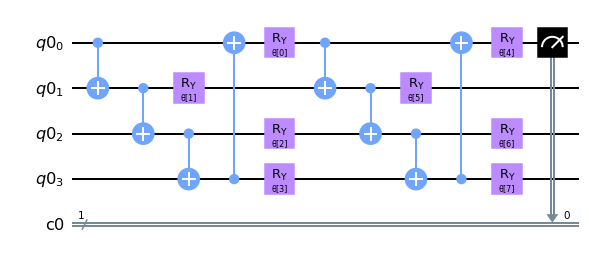

In [6]:
# Draw the variational model, adding a measurement on the first qubit
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
qc = variational_circuit(qc, ParameterVector('θ', 8))
qc.measure(0, c)
qc.draw()

In [7]:
# Define a function, containing the variational model
def quantum_nn(X, theta, simulator=True):

    qc, c = feature_map(X)
    qc.barrier()
    qc = variational_circuit(qc, theta)
    qc.barrier()
    qc.measure(0, c)

    shots = 10000
    backend = Aer.get_backend('qasm_simulator')
    
    if not simulator:
        shots = 1000
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_athens')
    
    job = backend.run(qc, shots=shots)

    result = job.result()
    counts = result.get_counts()
    
    return counts['1']/shots


In [8]:
# Define different types of loss functions
def loss(prediction, target):
    return (prediction - target)**2

def log_loss(prediction, target):
    return - (target * np.log(prediction))  - ((1-target) * np.log(1-prediction))

In [9]:
# Define the gradient function
def gradient(X, Y, theta):
    delta = 0.01
    grad = []
    for i in range(len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        pred1 = quantum_nn(X, dtheta)
        pred2 = quantum_nn(X, theta) 
        
        grad.append((log_loss(pred1, Y) - log_loss(pred2, Y))/delta)
        
    return np.array(grad)

In [10]:
# Define an accuracy function to check the performance of the model
def accuracy(X, Y, theta):
    
    counter = 0
    for X_i, Y_i in zip(X, Y):
        prediction = quantum_nn(X_i, theta)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [11]:
# Train the model
eta = 0.05
loss_list = []
theta = np.ones(2*N)

print('Epoch \t Loss \t Training Accuracy')

# Go through the epochs
for i in range(20):
    
    loss_tmp = []
    # For each epoch go through the data
    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(log_loss(prediction, Y_i))
        
        # Update the parameters
        theta = theta - eta * gradient(X_i, Y_i, theta)
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

Epoch 	 Loss 	 Training Accuracy
0 	 0.645 	 0.836
1 	 0.416 	 0.970
2 	 0.388 	 0.896
3 	 0.382 	 0.866
4 	 0.346 	 0.985
5 	 0.353 	 0.940
6 	 0.361 	 0.985
7 	 0.314 	 0.985
8 	 0.326 	 0.970
9 	 0.321 	 0.985
10 	 0.349 	 0.970
11 	 0.326 	 0.970
12 	 0.326 	 0.940
13 	 0.346 	 0.985
14 	 0.338 	 0.866
15 	 0.366 	 0.985
16 	 0.314 	 0.970
17 	 0.325 	 0.970
18 	 0.346 	 0.985
19 	 0.326 	 1.000


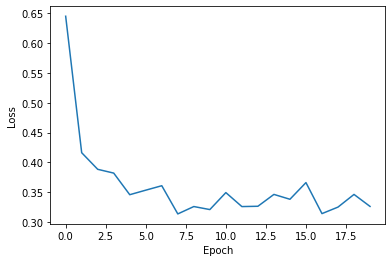

In [12]:
# Plot the loss function
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
# Check the accuracy of the model on the test set
accuracy(X_test, Y_test, theta)

0.9696969696969697